Import the required modules

In [6]:
"""Import the required modules"""
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.linalg import pinv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

In [2]:
def get_table(file, t_var):
    
  # Reads in files.
  df = pd.read_csv(file)
  # Save the target variables.
  t = df[t_var]
  # Drop target variables from df.
  df.drop(t_var, axis=1, inplace=True)
  # Create dummy variables.
  df = pd.get_dummies(df)
  # Join target variables to df
  df = pd.concat([df, t], axis=1)

  return df


In [3]:
file = 'welding_data_by_properties.csv', 'fibre_data.csv'
df = get_table(file[0], ['saw', 'smaw', 'gmaw', 'gtaw'])
df.head()

,current,voltage,welding_speed,plate_thickness,property_flexural_strength,property_hardness,property_heat_input,property_residual_stress,property_tensile_strength,saw,smaw,gmaw,gtaw
0,160,28,90,10,1,0,0,0,0,268.2,273.4,280.6,230.0
1,160,32,120,6,0,0,1,0,0,2560.0,2048.0,2048.0,1536.0
2,100,24,90,6,0,0,1,0,0,1600.0,1280.0,1280.0,960.0
3,100,28,120,8,0,1,0,0,0,128.4,134.5,132.5,86.4
4,100,24,90,6,0,0,0,1,0,272.4,216.8,230.4,125.8


In [4]:
def explore(df, p_start_cols, p_end_cols, t_start_cols, t_end_cols, n_plots, x):
  pos = 1
  for i in range(p_start_cols, p_end_cols):
    print(f'\t{df.columns[i].capitalize()} vs Response values')
    plt.figure(figsize=[15, 5])
    for j in range(t_start_cols, t_end_cols+x):
      plt.subplot(1, n_plots, pos)
      plt.scatter(df.iloc[:, i], df.iloc[:, j])
      plt.ylabel(df.columns[j])
      plt.xlabel(df.columns[i])
      pos += 1
    plt.tight_layout()
    plt.show()
    print('\n')
    pos = 1

In [5]:
table = ['Welding Data by Properties', 'Welding Data by Welding types']
for x in range(2):
    print(table[x])

    print('\nData Statistical Summary')
    display(df[x].describe())
    print('')

    print('\nExplore data graphically')
    explore(df[x], 0, 4, 9-x, 13-x, 4+x, x)

Welding Data by Properties

Data Statistical Summary


KeyError: 0

In [6]:
def generate_train_test(i, df):
  X = df[i].iloc[:, :9-i]
  y = df[i].iloc[:, -4:]

  return train_test_split(X, y,random_state=1, test_size=0.2)

In [7]:
def scale_data(X_train, X_test):
    sc_X = StandardScaler()
    X_trainscaled=sc_X.fit_transform(X_train)
    X_testscaled=sc_X.transform(X_test)

    return X_trainscaled, X_testscaled

In [8]:
def ann_analysis():
    X_trainscaled, X_testscaled = scale_data(X_train, X_test)
    reg = MLPRegressor(hidden_layer_sizes=(64, 64, 64), activation='relu', random_state=1, max_iter=5000).fit(X_trainscaled, y_train)

    y_pred=reg.predict(X_testscaled)
    r2 = r2_score(y_pred, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    return r2, rmse, mae, y_pred, reg

In [9]:
def elm_analysis(hidden_size=5000):
  input_size = X_train.shape[1]
  hidden_size = hidden_size
  input_weights = np.random.normal(size=[input_size,hidden_size])
  biases = np.random.normal(size=[hidden_size])

  def relu(x):
    return np.maximum(x, 0, x)

  def hidden_nodes(X):
      G = np.dot(X, input_weights)
      G = G + biases
      H = relu(G)
      return H

  output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)

  def predict(X):
      out = hidden_nodes(X)
      out = np.dot(out, output_weights)
      return out

  y_pred = predict(X_test)
  r2 = r2_score(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)

  return r2, rmse, mae, y_pred

In [10]:
def disp_matrics(r2, rmse, mae, title):
  print(title)
  print('===============================================')
  print(f'R^2:\t{r2}')
  print(f'rmse:\t{rmse}')
  print(f'mae:\t{mae}')
  print('\n')

In [11]:
def disp_graphs(i, y_test, y_ann_pred, y_elm_pred):
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.scatter(y_ann_pred, y_test)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
  plt.title('ANN')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')

  plt.subplot(1, 2, 2)
  plt.scatter(y_elm_pred, y_test)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
  plt.title('ELM')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')

  plt.suptitle('Comparing Models Predictive Abilities', x=.506, y=1.03, fontsize=16)
  plt.tight_layout()
  plt.show()

In [12]:
def disp_compare_graphs():
  plt.figure(figsize = (10, 5))

  x = np.arange(3)
  ann = [ann_r2*100, ann_rmse, ann_mae]
  elm = [elm_r2*100, elm_rmse, elm_mae]
  width = 0.40
    
  # plot data in grouped manner of bar type
  plt.bar(x-0.2, ann, width, color='green')
  plt.bar(x+0.2, elm, width, color='red')
  plt.xticks(x, ['R^2', 'RMSE', 'MAE'])
  plt.title("Comparing metrics for ANN and ELM")
  plt.xlabel("Metrics")
  plt.ylabel("Values")
  plt.legend(["ANN", "ELM"])
  plt.show()

MODEL MATRICS.
Analysis of table 1: Welding Data by Properties
Testing data:


,current,voltage,welding_speed,plate_thickness,property_flexural_strength,property_hardness,property_heat_input,property_residual_stress,property_tensile_strength
3,100,28,120,8,0,1,0,0,0
2,100,24,90,6,0,0,1,0,0
30,130,32,90,8,0,0,0,0,1
21,160,28,90,10,0,0,0,0,1
22,100,28,120,8,0,0,0,1,0
41,100,32,150,10,0,0,1,0,0
19,130,24,120,10,1,0,0,0,0
35,160,24,150,8,0,0,1,0,0
34,160,24,150,8,0,0,0,0,1


ANN modeling
Predicted values using ANN for Welding Data by Properties
C:\Users\NNAMDI\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


array([[  98.71770463,   96.3617683 ,   91.91809641,   43.17910015],
       [1401.00163959, 1118.07524011, 1122.92431567,  806.24353505],
       [ 522.01588407,  458.11598566,  486.84042128,  569.38571428],
       [ 673.80180873,  609.58885551,  643.17976687,  582.05849708],
       [ 169.54321594,  142.56785983,  147.57075436,   85.81496425],
       [1573.24166759, 1253.64272158, 1256.12335348,  963.27368137],
       [ 334.10737065,  275.74449094,  279.08622065,  307.86476829],
       [1541.1249549 , 1240.97823541, 1243.35907665,  903.76256224],
       [ 408.80427838,  373.22873817,  388.47186143,  379.60082603]])

The ANN model performance for testing set
R^2:	0.8837356454473266
rmse:	150.0590639165469
mae:	109.30604105192957


Analysis of table 1: Welding Data by Properties
Testing data:


,current,voltage,welding_speed,plate_thickness,property_flexural_strength,property_hardness,property_heat_input,property_residual_stress,property_tensile_strength
3,100,28,120,8,0,1,0,0,0
2,100,24,90,6,0,0,1,0,0
30,130,32,90,8,0,0,0,0,1
21,160,28,90,10,0,0,0,0,1
22,100,28,120,8,0,0,0,1,0
41,100,32,150,10,0,0,1,0,0
19,130,24,120,10,1,0,0,0,0
35,160,24,150,8,0,0,1,0,0
34,160,24,150,8,0,0,0,0,1


ELM modeling
Predicted values using ELM for Welding Data by Properties


array([[  84.21267252,   97.14858919,   90.54435813,   19.81360174],
       [1746.64743225, 1391.89602995, 1390.08243473, 1050.90074956],
       [ 416.34010434,  366.04887737,  400.80672   ,  477.37681343],
       [ 462.76129502,  399.7889861 ,  442.93761504,  492.45415568],
       [ 187.83383921,  169.90525555,  177.13123172,   73.43917686],
       [1341.22687267, 1085.37310391, 1089.31767567,  835.61920159],
       [ 280.1817771 ,  217.60637017,  220.69480023,  302.74894684],
       [1664.14937556, 1329.87876677, 1328.83121997,  988.0636298 ],
       [ 431.74971068,  411.62502662,  421.97590381,  395.27949562]])

The ELM model performance for testing set
R^2:	0.9718657761489308
rmse:	72.49632493010826
mae:	59.0982331792478






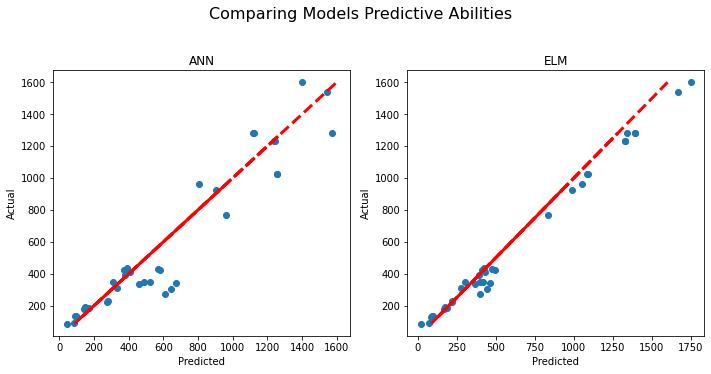

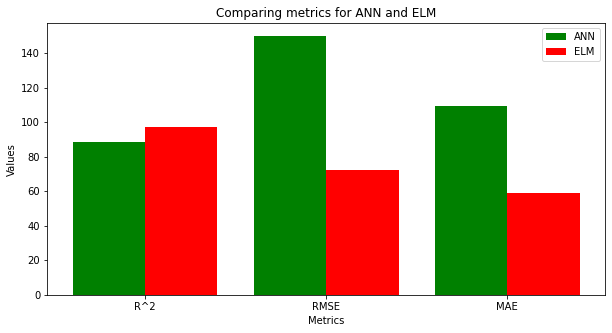

Analysis of table 2: Welding Data by Welding types
Testing data:


,current,voltage,welding_speed,plate_thickness,welding_type_GMAW,welding_type_GTAW,welding_type_SAW,welding_type_SMAW
30,100,28,120,8,1,0,0,0
34,100,24,90,6,0,0,0,1
28,100,24,90,6,0,1,0,0
3,160,28,90,10,0,1,0,0
19,100,32,150,10,0,0,0,1
17,160,32,120,6,0,0,0,1
21,130,24,120,10,0,1,0,0
23,100,32,150,10,0,1,0,0


ANN modeling
Predicted values using ANN for Welding Data by Welding types


array([[339.80175942, 202.32468911, 116.54844173, 187.6110801 ],
       [407.24013481, 258.64573129, 147.85855749, 237.66617601],
       [523.08318349, 431.0545074 , 125.37864876, 148.20088013],
       [358.01163353, 274.07367378,  98.04055796, 172.22866309],
       [287.42455297, 215.15764324, 137.67492206, 149.43917714],
       [309.11510218, 232.96440871,  94.85933066, 250.00535537],
       [417.31608697, 293.81276323, 109.45336954, 110.75661473],
       [326.8589183 , 320.16451771,  72.93177328,  80.16145254]])

The ANN model performance for testing set
R^2:	0.469605876421433
rmse:	40.02600646114289
mae:	28.64467314983191


Analysis of table 2: Welding Data by Welding types
Testing data:


,current,voltage,welding_speed,plate_thickness,welding_type_GMAW,welding_type_GTAW,welding_type_SAW,welding_type_SMAW
30,100,28,120,8,1,0,0,0
34,100,24,90,6,0,0,0,1
28,100,24,90,6,0,1,0,0
3,160,28,90,10,0,1,0,0
19,100,32,150,10,0,0,0,1
17,160,32,120,6,0,0,0,1
21,130,24,120,10,0,1,0,0
23,100,32,150,10,0,1,0,0


ELM modeling
Predicted values using ELM for Welding Data by Welding types


array([[321.32485791, 209.31212264, 138.79094896, 188.41020329],
       [433.85311082, 239.42409686, 131.5577266 , 219.14884595],
       [466.11454963, 321.00491208, 104.64579193, 117.8756796 ],
       [385.84928601, 307.18173547, 100.90915151, 180.06288222],
       [274.92707695, 205.10557277, 134.31136301, 152.19825944],
       [357.74208337, 235.17913562, 110.37518463, 262.45695913],
       [427.63653267, 300.12139578,  94.1311141 , 107.20348681],
       [362.64004764, 363.61263954,  74.65642072,  71.48943946]])

The ELM model performance for testing set
R^2:	0.7752099358485119
rmse:	26.17240674027364
mae:	17.70450232784174






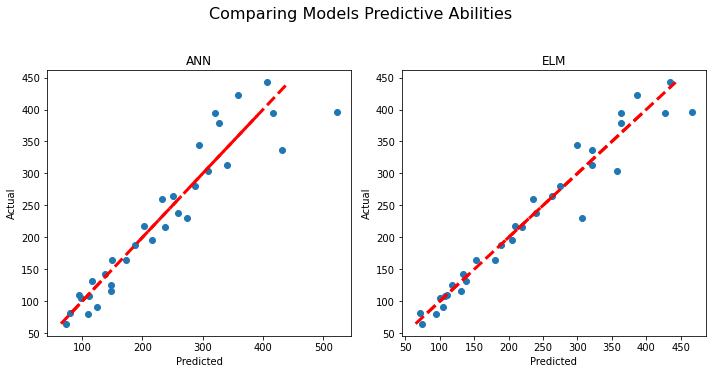

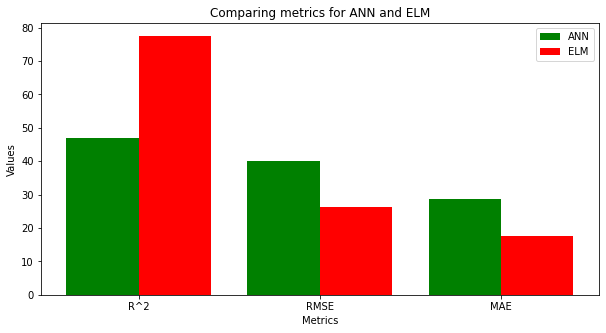

In [13]:
print('MODEL MATRICS.')
print('===============================================')

# df[0].drop(df[0].iloc[:, 4:5], inplace=True, axis=1)
# df[1].drop(df[1].iloc[:, 4:5], inplace=True, axis=1)

for i in range(2):
    for model in ['ANN', 'ELM']:
        print(f'Analysis of table {i+1}: {table[i]}')
        X_train, X_test, y_train, y_test = generate_train_test(i, df)

        print('Testing data:')
        display(X_test)

        if model == 'ANN':
            print('ANN modeling')
            ann_r2, ann_rmse, ann_mae, y_ann_pred, reg = ann_analysis()

            print(f'Predicted values using ANN for {table[i]}')
            display(y_ann_pred)
            disp_matrics(ann_r2, ann_rmse, ann_mae, 'The ANN model performance for testing set')
        else:
            print('ELM modeling')
            elm_r2, elm_rmse, elm_mae, y_elm_pred = elm_analysis()

            print(f'Predicted values using ELM for {table[i]}')
            display(y_elm_pred)
            disp_matrics(elm_r2, elm_rmse, elm_mae, 'The ELM model performance for testing set')

    print('\n')

    disp_graphs(i, y_test, y_ann_pred, y_elm_pred)
    disp_compare_graphs()